# Overview

This notebook in intended as a generic notebook to be used with the papermill python library to allow automated generation of analyses and reports for classifiers on microbiome data generated by kraken2 pipeline

In [1]:
cd /project/src

/project/src


In [2]:
from sklearn import model_selection
from sklearn import metrics
import os
import re
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import math as math
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt
# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Basic Data Loading

In [3]:
inp_mat_file = '/project/data/raw/justin_paired_end_run_jul_6_2021/PE_50K_freq_mat.csv'
metadata_file = '/project/data/raw/Jie_2017_supp_table_1.xlsx'
identifiers_file = '/project/data/raw/SRA/all_runs.csv'
output_dir = '/project/results/LR_Classifier_generic'
retrain = True

In [4]:
def read_table(fpath, **kwargs):
    """
    read csv or excel file
    
    fpath = filepath
    **kwargs = other arguments to pandas.read_csv or pandas.read_excel
    
    returns: pandas dataframe
    """
    
    if re.search('\\.xls(x)*$', fpath):
        df = pd.read_excel(fpath, **kwargs)
    elif re.search('\\.csv$', fpath):
        df = pd.read_csv(fpath, **kwargs)
    else:
        raise ValueError('Unexpected file type for file {}'.format(fpath))
        
    return df

In [5]:
inp_mat = read_table(inp_mat_file)
matrix_cols = inp_mat.columns[1:len(inp_mat.columns)]
inp_mat['RunID'] = np.array([re.findall('^[A-Z]{3}[0-9]+', x)[0] for x in inp_mat['filename'].to_numpy().astype('str')])
inp_mat = inp_mat.loc[:, np.concatenate((['filename', 'RunID'], matrix_cols.to_numpy()))]
inp_mat.head()

,filename,RunID,Homo sapiens,Blochmannia endosymbiont of Camponotus (Colobopsis) obliquus,Blochmannia endosymbiont of Camponotus nipponensis,Blochmannia endosymbiont of Colobopsis nipponica,Blochmannia endosymbiont of Polyrhachis (Hedomyrma) turneri,Bovine nidovirus 1,Candidatus Aquiluna sp. 15G-AUS-rot,Candidatus Aquiluna sp. UB-MaderosW2red,...,Lonomia obliqua nucleopolyhedrovirus,Microplitis demolitor bracovirus,Neodiprion sertifer nucleopolyhedrovirus,Oxyplax ochracea nucleopolyhedrovirus,Spodoptera exigua multiple nucleopolyhedrovirus,Spodoptera litura granulovirus,Spodoptera litura nucleopolyhedrovirus,Sulfolobales Mexican fusellovirus 1,Human feces pecovirus,Pacmanvirus A23
0,ERR2017411_seqt.subsampled_1_kneaddata_paired_...,ERR2017411,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ERR2017412_seqt.subsampled_1_kneaddata_paired_...,ERR2017412,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ERR2017413_seqt.subsampled_1_kneaddata_paired_...,ERR2017413,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERR2017414_seqt.subsampled_1_kneaddata_paired_...,ERR2017414,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERR2017415_seqt.subsampled_1_kneaddata_paired_...,ERR2017415,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
meta_data = read_table(metadata_file, skiprows=2)
meta_data.head()

,Sample ID,ACVD status,Coronary type,Age (year),Gender,Height (cm),Weight (kg),Body Mass Index (BMI),Waist (cm),Hip (cm),...,Bisoprolol_9,Fondaparinux Sodium_10,Metoprolol_19,Insulin aspart_6,Isosorbide dinitrate_10,Acarbose_7,Captopril Tablets_6,Estazolam_6,Nitroglycerin Tablets_8,Potassium chloride_32
0,N001,0,NaN,52.0,male,165.0,65.0,23.88,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N002,0,NaN,53.0,male,160.0,63.0,24.61,78.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N003,0,NaN,48.0,male,166.0,70.0,25.40,92.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N005,0,NaN,53.0,female,158.0,57.5,23.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N006,0,NaN,53.0,female,150.0,60.0,26.67,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
meta_data['Sample ID']

0        N001
1        N002
2        N003
3        N005
4        N006
        ...  
400    ZSL525
401    ZSL527
402    ZSL529
403    ZSL530
404    ZSL532
Name: Sample ID, Length: 405, dtype: object

In [8]:
identifiers = read_table(identifiers_file)
identifiers['Sample ID'] = identifiers.pop('Alias')
identifiers.head()

,Unnamed: 0,ExptAcc,RunID,Sample ID
0,0,ERX2076993,ERR2017411,N001
1,0,ERX2076994,ERR2017412,N002
2,0,ERX2076995,ERR2017413,N003
3,0,ERX2076996,ERR2017414,N005
4,0,ERX2076997,ERR2017415,N006


In [9]:
identifiers['Sample ID']

0        N001
1        N002
2        N003
3        N005
4        N006
        ...  
400    ZSL_58
401    ZSL_67
402     ZSL_6
403    ZSL_82
404    ZSL_96
Name: Sample ID, Length: 405, dtype: object

In [10]:
identifiers['Sample ID'] = identifiers['Sample ID'].astype('str')
meta_data['Sample ID'] = meta_data['Sample ID'].astype('str')
meta_data_full = pd.merge(identifiers, meta_data, how='left', on='Sample ID')
meta_data_full.head()

,Unnamed: 0,ExptAcc,RunID,Sample ID,ACVD status,Coronary type,Age (year),Gender,Height (cm),Weight (kg),...,Bisoprolol_9,Fondaparinux Sodium_10,Metoprolol_19,Insulin aspart_6,Isosorbide dinitrate_10,Acarbose_7,Captopril Tablets_6,Estazolam_6,Nitroglycerin Tablets_8,Potassium chloride_32
0,0,ERX2076993,ERR2017411,N001,0,NaN,52.0,male,165.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,ERX2076994,ERR2017412,N002,0,NaN,53.0,male,160.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,ERX2076995,ERR2017413,N003,0,NaN,48.0,male,166.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,ERX2076996,ERR2017414,N005,0,NaN,53.0,female,158.0,57.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,ERX2076997,ERR2017415,N006,0,NaN,53.0,female,150.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
meta_data_full.shape

(405, 58)

# Assemble and Clean Data

In [12]:
meta_data_full = meta_data_full.set_index('RunID')
meta_data_full = meta_data_full.loc[inp_mat['RunID'], :]
inp_mat = inp_mat.set_index('RunID')
# pop filenames from data frame
inp_mat.pop('filename')

RunID
ERR2017411    ERR2017411_seqt.subsampled_1_kneaddata_paired_...
ERR2017412    ERR2017412_seqt.subsampled_1_kneaddata_paired_...
ERR2017413    ERR2017413_seqt.subsampled_1_kneaddata_paired_...
ERR2017414    ERR2017414_seqt.subsampled_1_kneaddata_paired_...
ERR2017415    ERR2017415_seqt.subsampled_1_kneaddata_paired_...
                                    ...                        
ERR2017809    ERR2017809_seqt.subsampled_1_kneaddata_paired_...
ERR2017810    ERR2017810_seqt.subsampled_1_kneaddata_paired_...
ERR2017813    ERR2017813_seqt.subsampled_1_kneaddata_paired_...
ERR2017814    ERR2017814_seqt.subsampled_1_kneaddata_paired_...
ERR2017815    ERR2017815_seqt.subsampled_1_kneaddata_paired_...
Name: filename, Length: 385, dtype: object

In [13]:
feat_meta = pd.DataFrame({'feature': inp_mat.columns.to_numpy().astype('str')})
feat_meta

,feature
0,...
1,Blochmannia endosymbio...
2,Blochmannia endosymbio...
3,Blochmannia endosymbio...
4,Blochmannia endosymbio...
...,...
6496,Spodoptera litura granulovirus
6497,Spodoptera litura nucleopolyhedrovirus
6498,Sulfolobales Mexican fusellovirus 1
6499,Human feces pecovirus


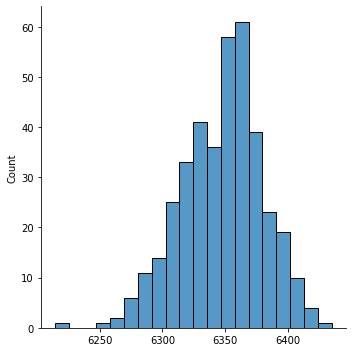

In [14]:
X = inp_mat.to_numpy().astype('float32')
X[np.isnan(X)] = 0.
zero_feats = [np.sum(X[i,:] == 0.) for i in range(X.shape[0])]
sns.displot(zero_feats)

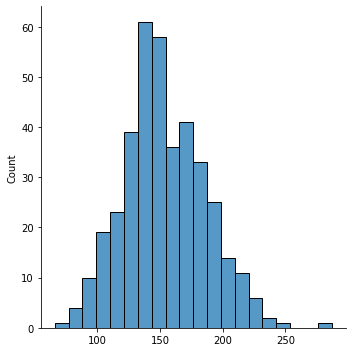

In [15]:
nonzero_feats = [np.sum(X[i,:] != 0.) for i in range(X.shape[0])]
sns.displot(nonzero_feats)

In [16]:
X_centered = X - (X.sum(axis=0)/X.shape[1])
col_vars = np.power(X_centered, 2).sum(axis=0)/X.shape[1]

In [17]:
sum(col_vars == 0)

4559

In [18]:
feats_keep = col_vars != 0
X = X[:, feats_keep]
inp_mat = inp_mat.iloc[:, feats_keep]
feat_meta = feat_meta.iloc[feats_keep, :]
X.shape

(385, 1942)

In [19]:
# check that all values of x are gte 0
assert np.all(X >= 0)

In [20]:
# these samples, if they exist, have 0 detected features
zero_samples = X.sum(axis=1) == 0
# if this is True, then we'd need to remove some samples
any_zero_samples = np.any(zero_samples)
any_zero_samples

False

In [21]:
if any_zero_samples:
    samples_keep = np.logical_not(zero_samples)
    X = X[samples_keep, :]
    meta_data_full = meta_data_full.iloc[samples_keep, :]

In [22]:
print(X.shape)
print(meta_data_full.shape)

(385, 1942)
(385, 57)


In [23]:
y = meta_data_full['ACVD status'].to_numpy().astype('int32')

In [24]:
y.shape

(385,)

# Quick PCA of Data

In [25]:
std_scaler_full = StandardScaler()
X_scaled_full = std_scaler_full.fit_transform(X)
PCA_full = PCA()
X_PCA_full = PCA_full.fit_transform(X_scaled_full)

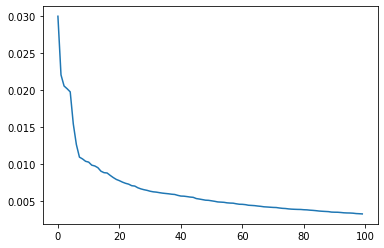

In [26]:
plt.plot(PCA_full.explained_variance_ratio_[0:100])

In [27]:
PCA_plot_df = pd.DataFrame(X_PCA_full, columns = np.array(['PC{}'.format(i) for i in range(1, X_PCA_full.shape[1] + 1)]))

In [28]:
PCA_plot_df['ACVD status'] = y

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

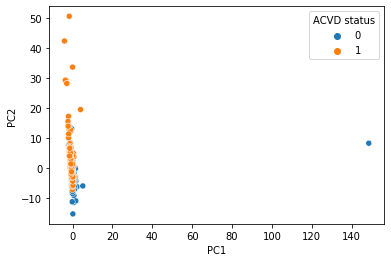

In [29]:
sns.scatterplot(data=PCA_plot_df, x='PC1', y='PC2', hue='ACVD status')

<AxesSubplot:xlabel='PC2', ylabel='PC3'>

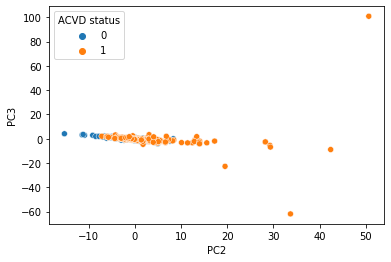

In [30]:
sns.scatterplot(data=PCA_plot_df, x='PC2', y='PC3', hue='ACVD status')

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

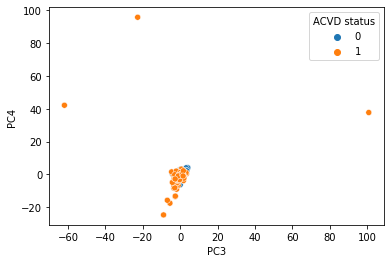

In [31]:
sns.scatterplot(data=PCA_plot_df, x='PC3', y='PC4', hue='ACVD status')

<AxesSubplot:xlabel='ACVD status', ylabel='PC3'>

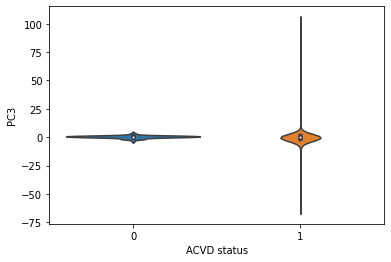

In [32]:
sns.violinplot(data=PCA_plot_df, x='ACVD status', y='PC3')

<AxesSubplot:xlabel='ACVD status', ylabel='PC4'>

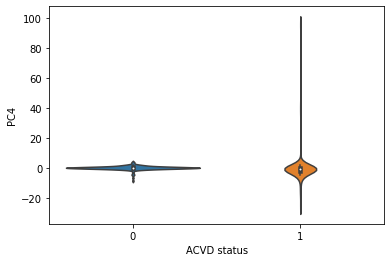

In [33]:
sns.violinplot(data=PCA_plot_df, x='ACVD status', y='PC4')

In [34]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

n_splits = 10
out_path = os.path.join(output_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(output_dir):
        os.system('rm -rf ' + output_dir)
    os.mkdir(output_dir)
    # random seed here deals with model initialization
    # random seed here deals with model initialization
    clf = xgb.XGBClassifier(objective="binary:logistic", 
                            eval_metric="logloss", 
                            gamma=5, subsample=0.5, 
                            max_delta_step=1, 
                            scale_pos_weight=math.sqrt(1721
    /328))
    param_grid = {'eta': [0.3],
                 'max_depth': [2,4,6,8],
                 'n_estimators': [3,5,10,20]}
    MyModel = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(RECALL_SCORE), cv = 5)

    # setup pipeline and Trainer
    MyPipeLine = Pipeline([('scaler0', StandardScaler()), ('pca', PCA(n_components=20))])
    MyTrainer = Trainer(model=MyModel, pipeline_X=MyPipeLine)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()

Running for split 1 of 10
Using predict_proba
getting predictions from probs
Running for split 2 of 10
Using predict_proba
getting predictions from probs
Running for split 3 of 10
Using predict_proba
getting predictions from probs
Running for split 4 of 10
Using predict_proba
getting predictions from probs
Running for split 5 of 10
Using predict_proba
getting predictions from probs
Running for split 6 of 10
Using predict_proba
getting predictions from probs
Running for split 7 of 10
Using predict_proba
getting predictions from probs
Running for split 8 of 10
Using predict_proba
getting predictions from probs
Running for split 9 of 10
Using predict_proba
getting predictions from probs
Running for split 10 of 10
Using predict_proba
getting predictions from probs


In [35]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.713598,train
1,0.648512,train
2,0.792957,train
3,0.762020,train
4,0.862209,train
5,0.782751,train
6,0.837218,train
7,0.758060,train
8,0.651065,train
9,0.794048,train


<AxesSubplot:xlabel='stage', ylabel='score'>

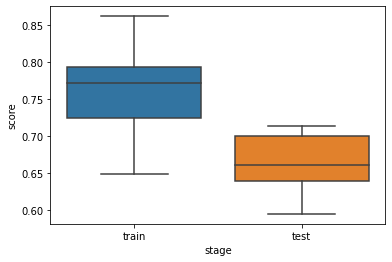

In [36]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [37]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [38]:
FinalModel.model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='logloss', gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.2906224524159793, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
hyperparams = {'max_depth': [], 'n_estimators': []}
for i in range(n_splits):
    hyperparams['max_depth'].append(MyMultiTrainTester.TrainerList[i].model.best_estimator_.max_depth)
    hyperparams['n_estimators'].append(MyMultiTrainTester.TrainerList[i].model.best_estimator_.n_estimators)
    
hyperparams_df = pd.DataFrame(hyperparams)
hyperparams_df

,max_depth,n_estimators
0,6,3
1,2,5
2,4,10
3,6,5
4,8,20
5,6,10
6,8,20
7,6,5
8,2,5
9,8,10


<AxesSubplot:xlabel='score_type', ylabel='value'>

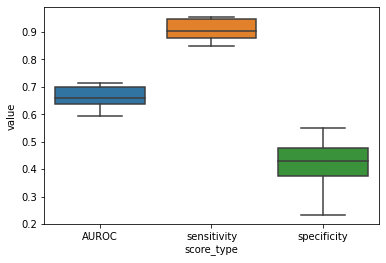

In [40]:
def AUROC_SCORE(y_true, y_pred):
    return metrics.roc_auc_score(y_true, y_pred, average='macro')
def SENSITIVITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=1)
def SPECIFICITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=0)

scorer_list = [AUROC_SCORE, SENSITIVITY_SCORE, SPECIFICITY_SCORE]
scorer_names = ['AUROC', 'sensitivity', 'specificity']
other_metrics = {'split': [], 'score_type': [], 'value': []}
for i in range(n_splits):
    test_idx = MyMultiTrainTester.test_idx[i]
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    Trainer_i = MyMultiTrainTester.TrainerList[i]
    for j in range(len(scorer_list)):
        score_type = scorer_names[j]
        score_func = scorer_list[j]
        other_metrics['split'].append(i)
        other_metrics['score_type'].append(score_type)
        other_metrics['value'].append(Trainer_i.score(X_test, y_test, score_func))
    
other_metrics_df = pd.DataFrame(other_metrics)
sns.boxplot(data = other_metrics_df, x = 'score_type', y = 'value')

In [41]:
# median sensitivity
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'sensitivity'])

0.9024621212121212

In [42]:
# std dev
np.std(other_metrics_df['value'][other_metrics_df['score_type'] == 'sensitivity'])

0.03665192944822417

In [43]:
# median specificity
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'specificity'])

0.428921568627451

In [44]:
# std dev
np.std(other_metrics_df['value'][other_metrics_df['score_type'] == 'specificity'])

0.10321116616940852

In [45]:
other_metrics_df.to_csv(os.path.join(output_dir, 'misc_score_metrics.csv'))

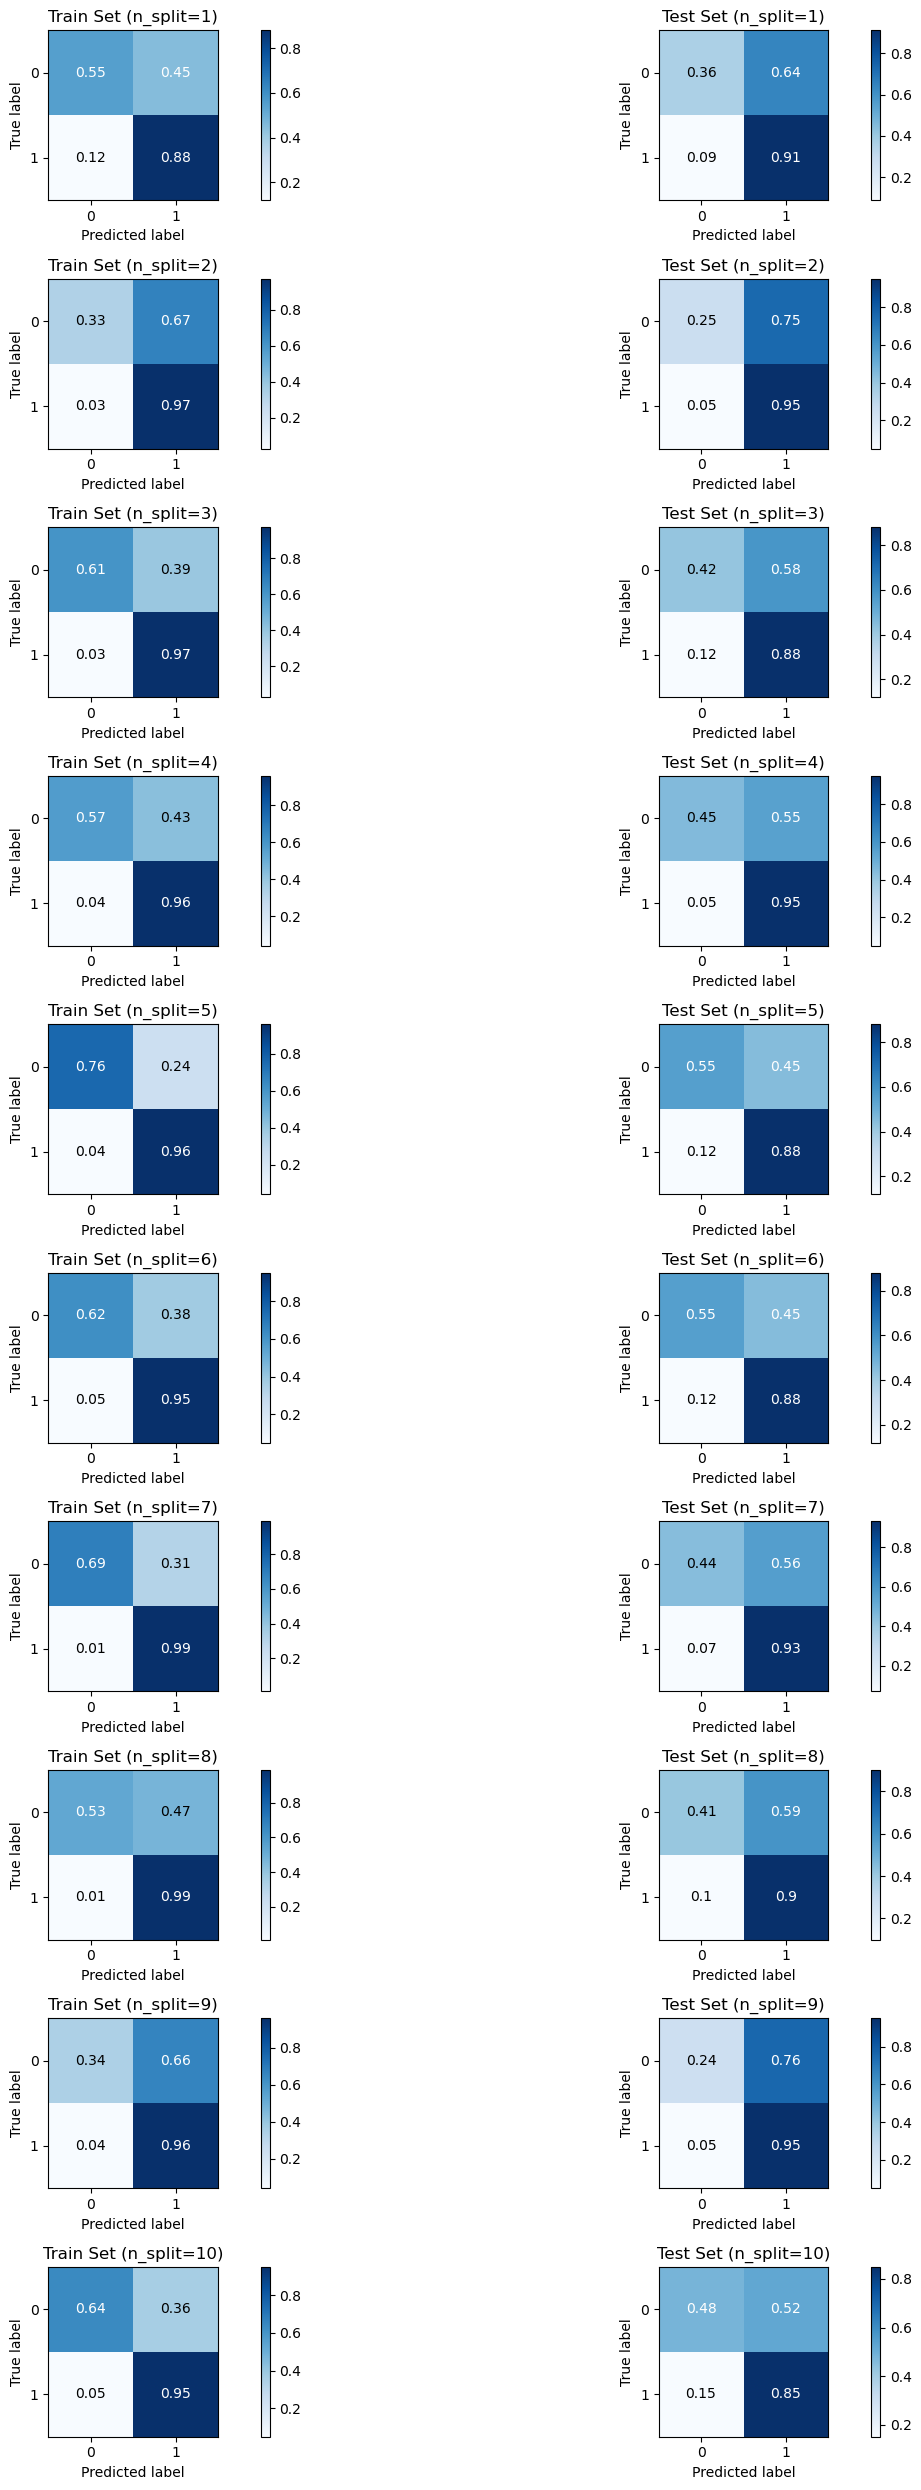

In [46]:
MyMultiTrainTester.plot_confusion(normalize=True, figsize=(15,25))

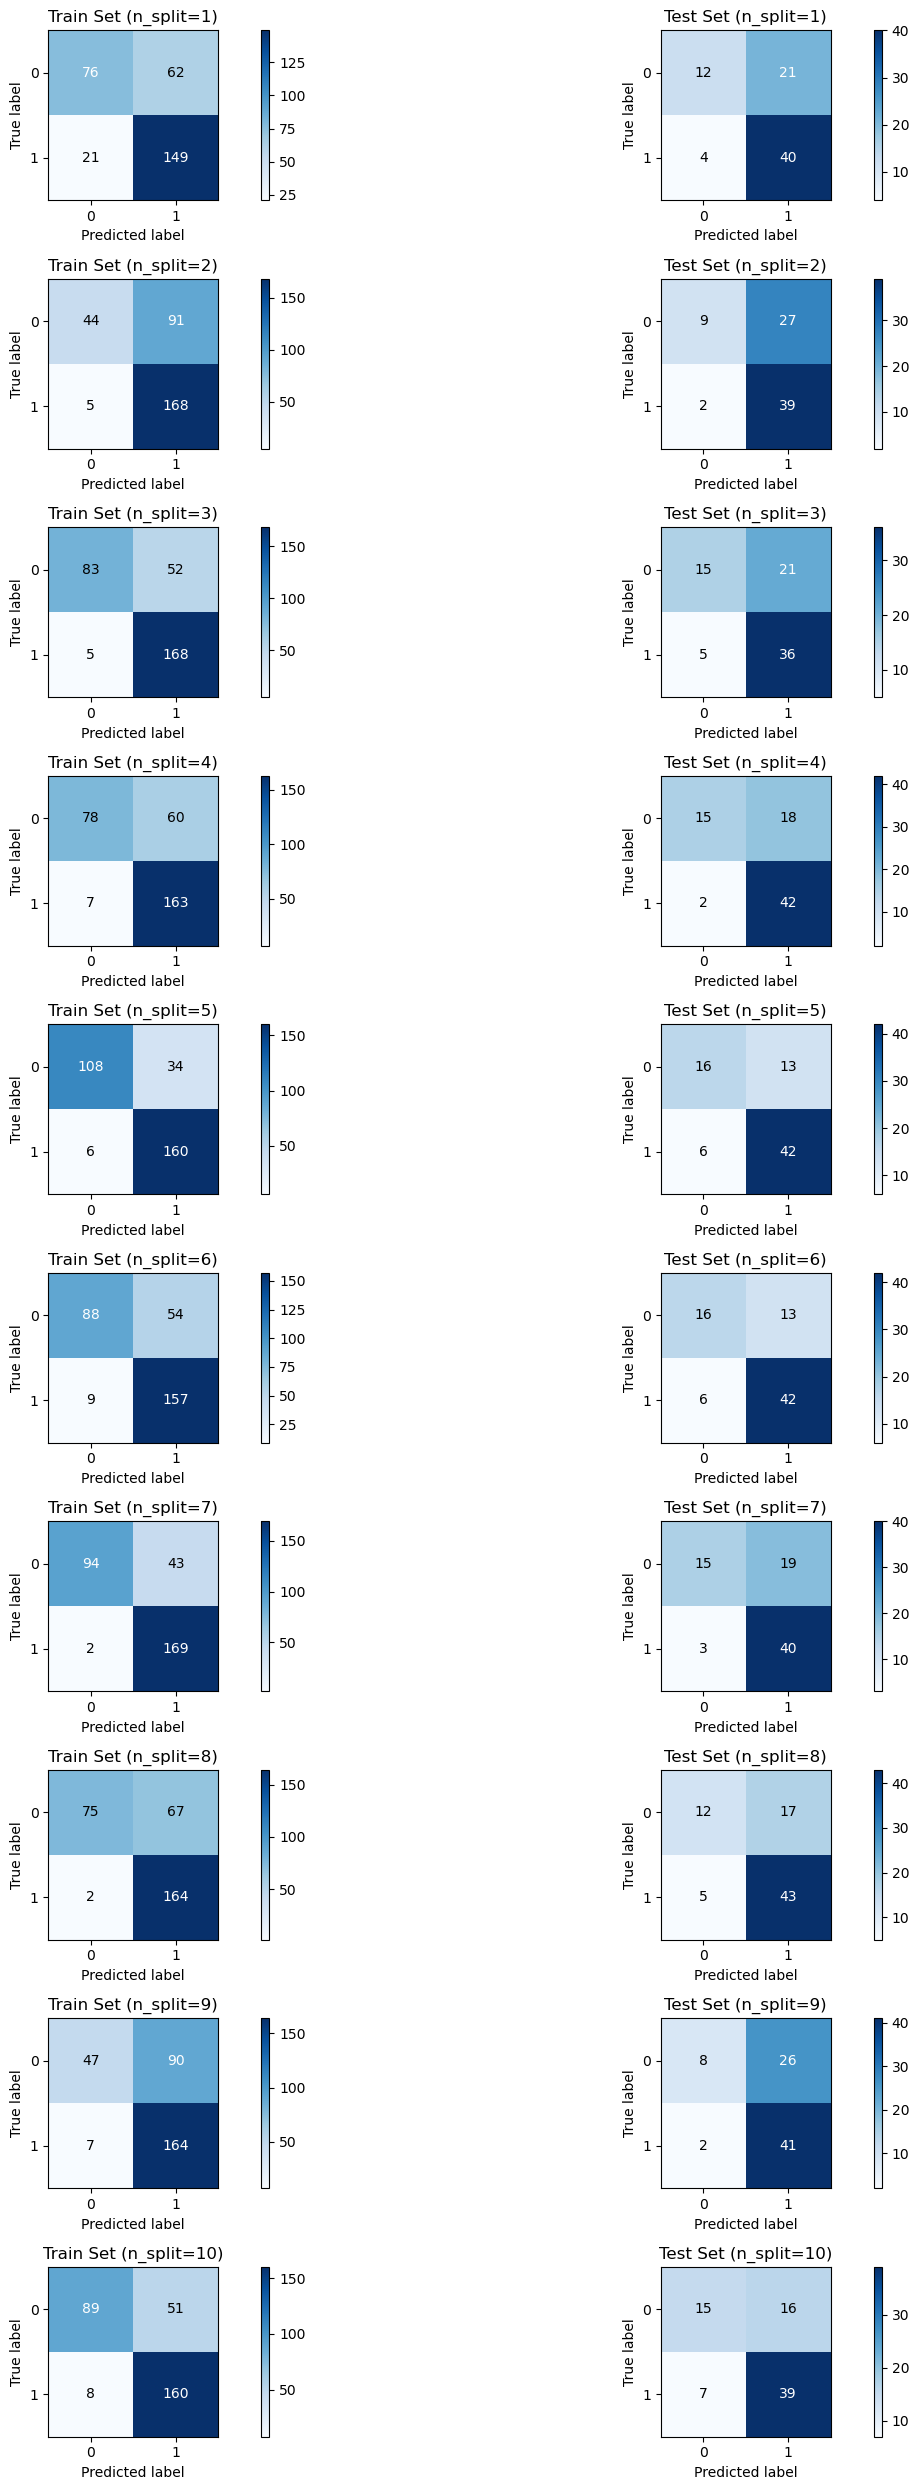

In [47]:
MyMultiTrainTester.plot_confusion(normalize=False, figsize=(15,25))

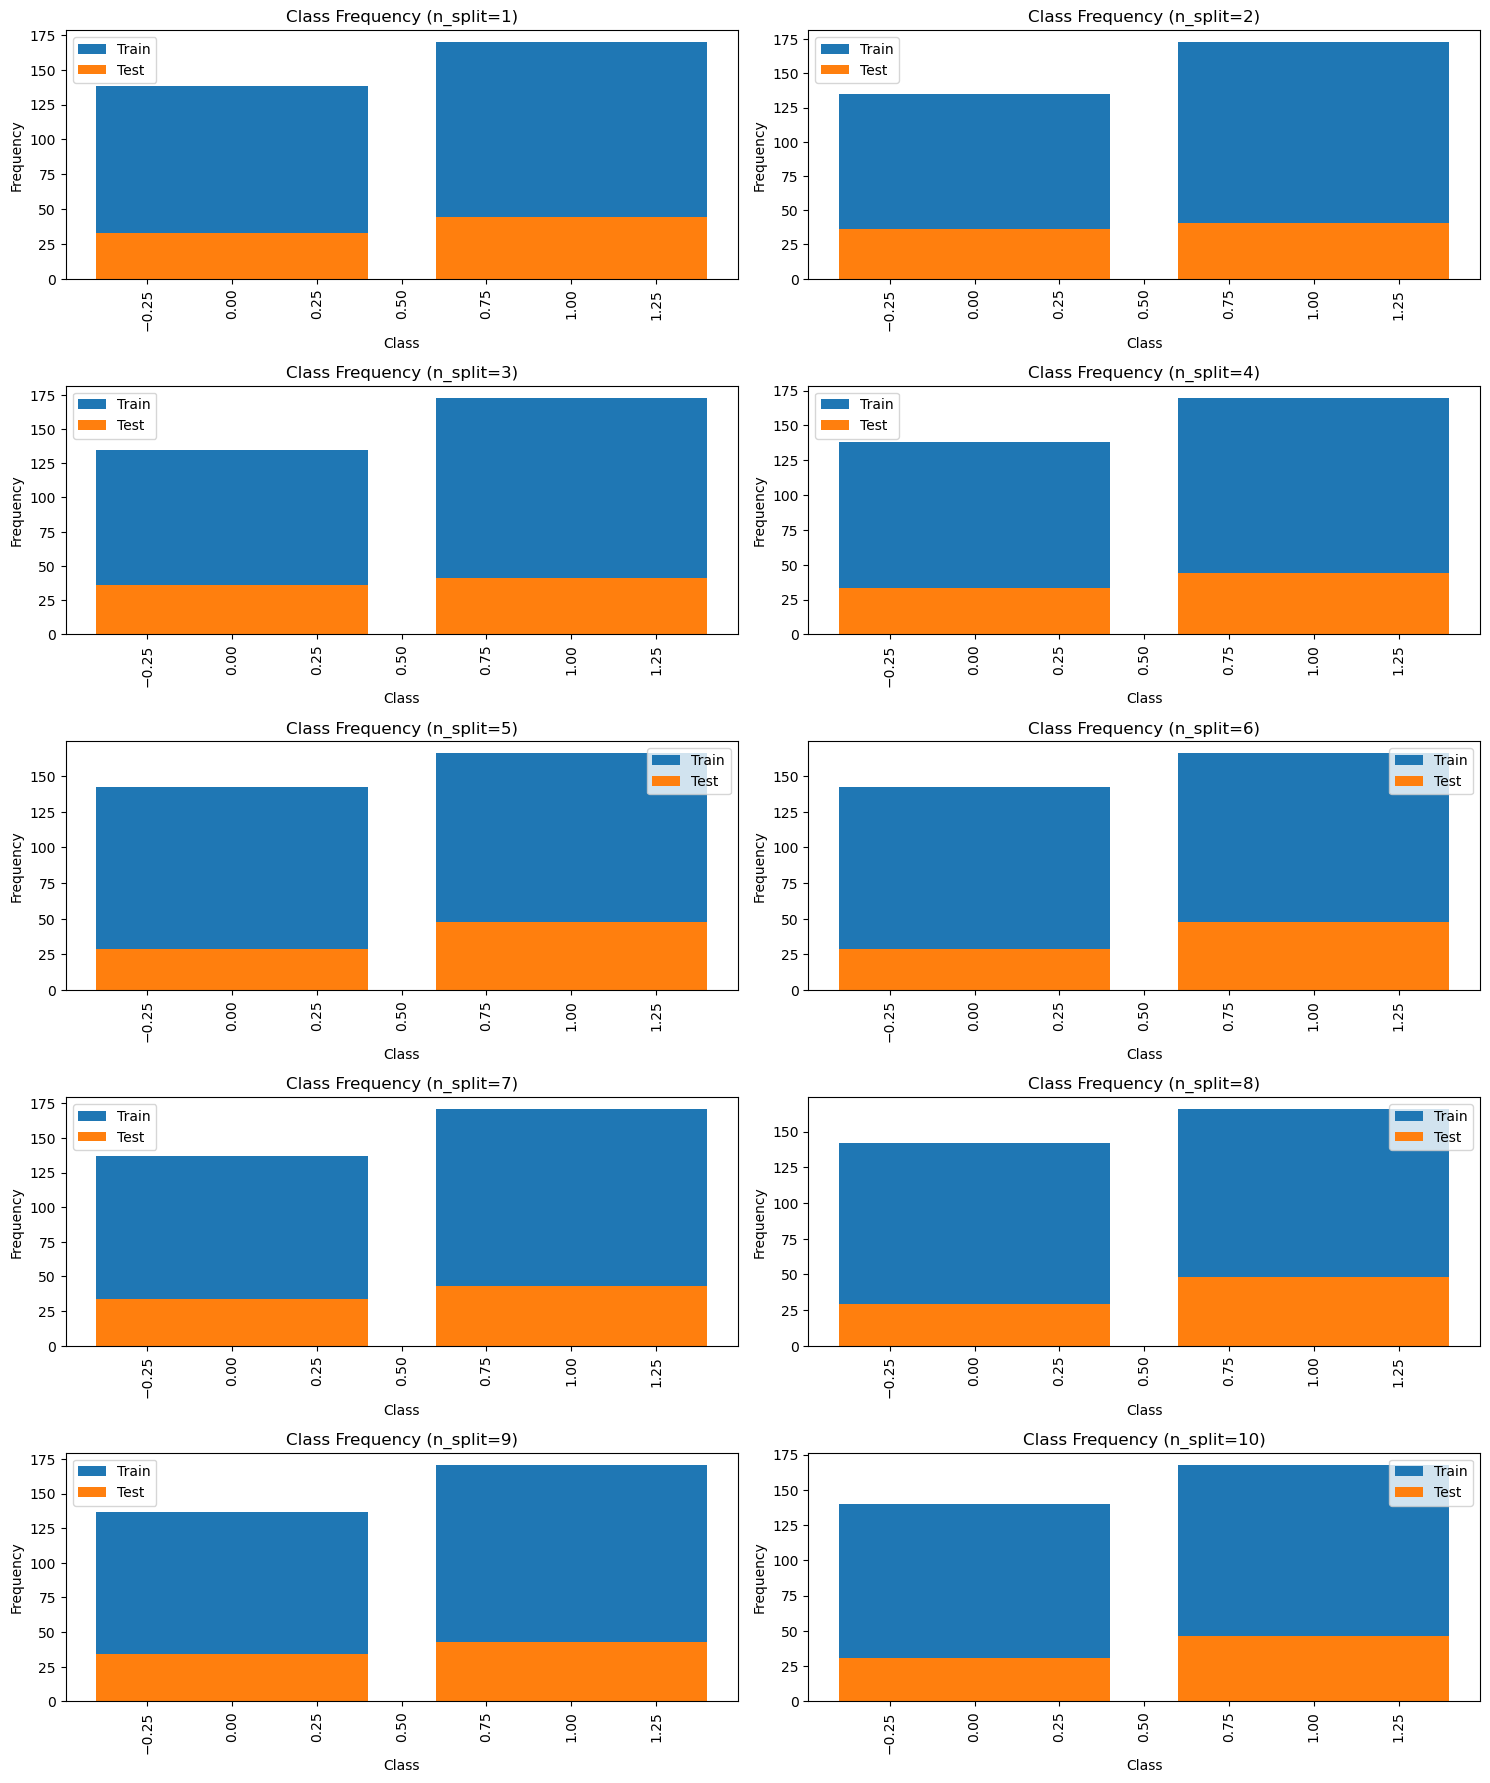

In [48]:
MyMultiTrainTester.plot_class_freq(normalize=True, figsize=(15,35))

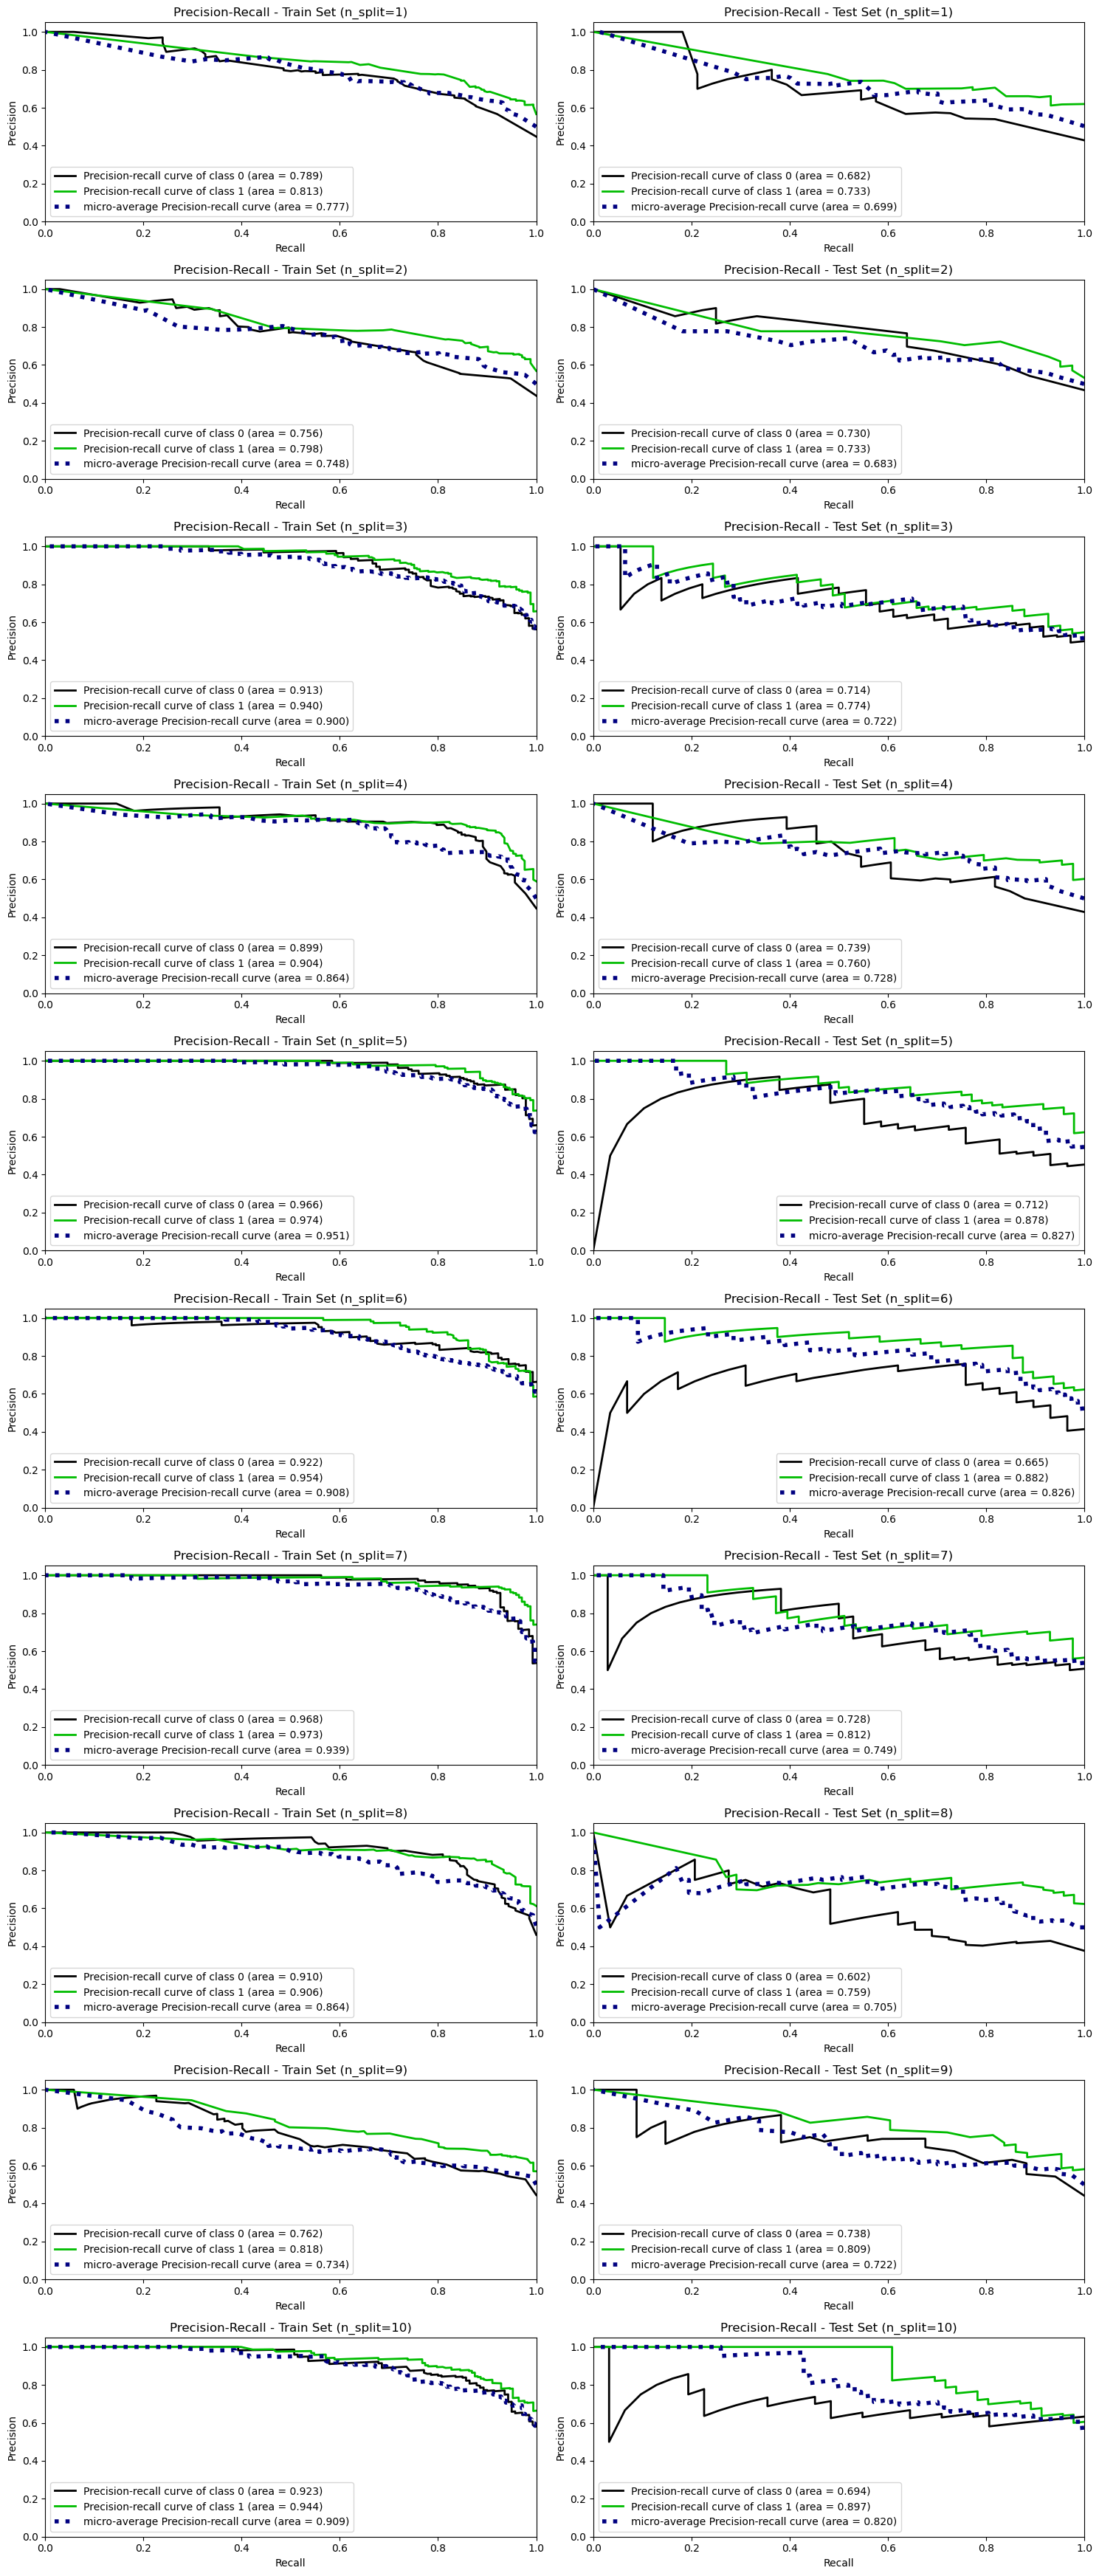

In [49]:
MyMultiTrainTester.plot_precrecall(figsize=(15,35))